# DBSCAN 성능평가

> iris 데이터 셋

## #01. 준비작업

### [1] 패키지 가져오기

In [13]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기 - IRIS

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/iris.xlsx", info=False, categories=['Species'])

## #02. 데이터 전처리

1. 종속변수 제거
2. 데이터 스케일링

In [3]:
# 종속변수를 별도로 분리했음에 유의
y = origin['Species']

df1 = origin.drop(columns=['Species'])
df2 = my_standard_scaler(df1)

## #03. 군집화 모델 

### [1] k개의 최근접 이웃 만들기

In [4]:
k = 5

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X=df2)

# 한 점의 최근접 이웃 찾기
distance, indices = neighbors_fit.kneighbors(df2)

# 가까운 순서대로 정렬
s_distance = np.sort(distance, axis=0)

# 각 데이터 포인트로부터의 거리
target = s_distance[:, k-1]
target

array([0.23710977, 0.23710977, 0.24891184, 0.24891184, 0.26013882,
       0.26013882, 0.26013882, 0.26013882, 0.2662756 , 0.2662756 ,
       0.27119749, 0.27119749, 0.28389113, 0.28646987, 0.28851266,
       0.28851266, 0.29154628, 0.2970349 , 0.29828781, 0.31104122,
       0.31292365, 0.31292365, 0.32423461, 0.32423461, 0.33424117,
       0.33774794, 0.34971228, 0.35304268, 0.35304268, 0.35430096,
       0.35740948, 0.35781942, 0.35922722, 0.35922722, 0.36369587,
       0.36369587, 0.36572241, 0.36772361, 0.36792033, 0.37544202,
       0.37678398, 0.37678398, 0.38717219, 0.38906698, 0.39599996,
       0.39599996, 0.39637   , 0.4015088 , 0.40749818, 0.40749818,
       0.40749818, 0.4114466 , 0.4114466 , 0.42253561, 0.42547067,
       0.42547067, 0.42547067, 0.42874557, 0.42925026, 0.43082001,
       0.43399991, 0.43435955, 0.43857884, 0.43872485, 0.44039444,
       0.44502517, 0.44866133, 0.44866133, 0.44866133, 0.44994717,
       0.44994717, 0.44994717, 0.45352282, 0.45836637, 0.46039

### [2] `eps`값 찾기

In [5]:
kl = KneeLocator(range(0, len(target)), target, curve="convex", direction="increasing")
eps = kl.elbow_y
point = kl.elbow
print("found elbow: ", eps)
print("found point: ", point)

found elbow:  0.7215753955580272
found point:  130


### [4] 군집

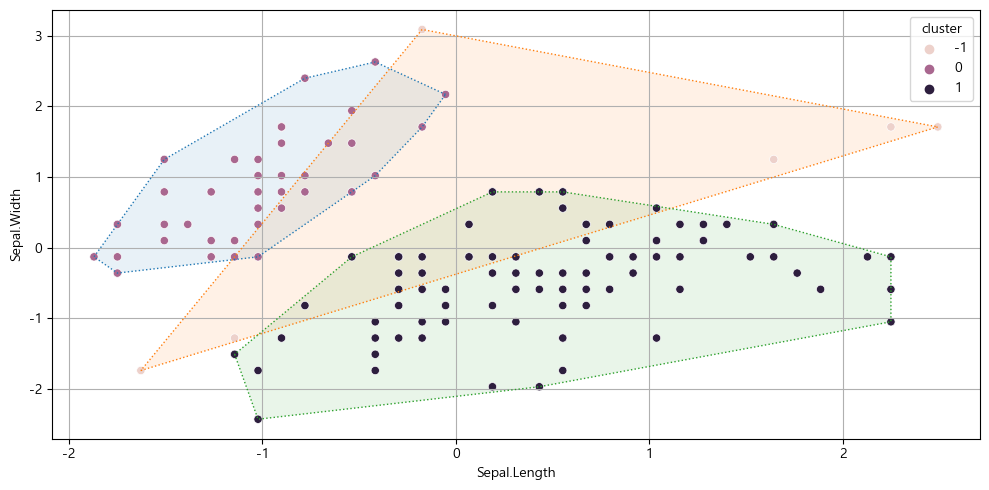

In [6]:
estimator = DBSCAN(eps=eps, min_samples=k, n_jobs=-1)
estimator.fit(df2)

result_df = df2.copy()
result_df['cluster'] = estimator.labels_
my_convex_hull(data=result_df, xname=result_df.columns[0], yname=result_df.columns[1], hue='cluster')

## #04. 벡터 구분하기

### [1] 핵심 벡터의 인덱스

학습에 사용된 데이터프레임에 대한 행 인덱스 목록

In [7]:
estimator.core_sample_indices_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  39,  40,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  58,  59,  61,  63,  64,  65,  66,  67,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 107, 110, 111, 112, 115, 116,
       120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 132, 133, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
      dtype=int64)

### [2] 핵심 백터('C'), 외곽 벡터('O'), 노이즈('N') 구분하기

In [8]:
rdf = result_df.copy()
rdf['vector'] = 'O'
rdf.loc[estimator.core_sample_indices_, 'vector'] = 'C'
rdf.loc[result_df['cluster'] == -1, 'vector'] = 'N'
rdf

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,cluster,vector
0,-0.900681,1.019004,-1.340227,-1.315444,0,C
1,-1.143017,-0.131979,-1.340227,-1.315444,0,C
2,-1.385353,0.328414,-1.397064,-1.315444,0,C
3,-1.506521,0.098217,-1.283389,-1.315444,0,C
4,-1.021849,1.249201,-1.340227,-1.315444,0,C
...,...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,1,C
146,0.553333,-1.282963,0.705921,0.922303,1,C
147,0.795669,-0.131979,0.819596,1.053935,1,C
148,0.432165,0.788808,0.933271,1.448832,1,C


In [9]:
rdf['vector'].value_counts()

C    130
O     14
N      6
Name: vector, dtype: int64

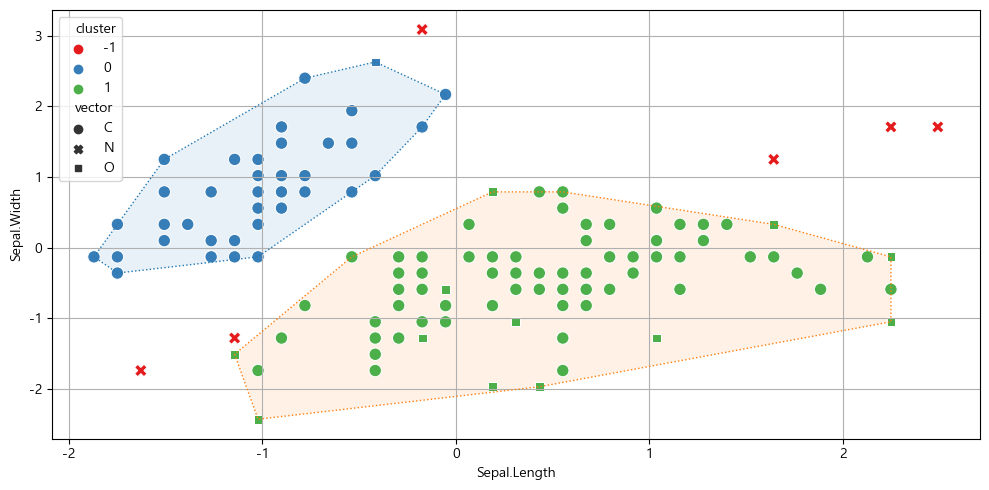

In [14]:
my_convex_hull(data = rdf, xname=result_df.columns[0], yname=result_df.columns[1], hue='cluster', palette='Set1', style='vector', s=80)

# my_convex_hull(data=rdf, xname=result_df.columns[0], yname=result_df.columns[1], hue='cluster',  palette='Set1')